<a href="https://colab.research.google.com/github/FatmaWaleed/Meditation-and-Thinking-Preprocessing/blob/main/Meditation_and_Thinking_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Document with links to all the relevant papers and datasets associated with this project
https://docs.google.com/document/d/17Xat1IGV2ZR0xrLTiJS14FC4u-qNq7edyCFK3Utr1Pc/edit?usp=sharing

Importing all the Important Libraries

In [ ]:
!pip install osfclient
!pip install mne
!pip install meegkit
!pip install pyriemann==0.2.4

#!pip install ipympl

import scipy.io as sio
import numpy as np
import pandas as pd
import requests
from collections import Counter
import os
from meegkit.asr import ASR
from meegkit.utils.matrix import sliding_window
import os, requests, tarfile
import mne
from scipy.signal import find_peaks
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from meegkit import asr
import warnings
from functools import wraps
import numpy as np
from scipy.linalg import block_diag
from scipy.stats import chi2
from sklearn.covariance import oas, ledoit_wolf, fast_mcd
import pyriemann.utils
import matplotlib.pyplot as plt
#from ipywidgets import interact


  Using cached pyriemann-0.2.4-py2.py3-none-any.whl (33 kB)
  Attempting uninstall: pyriemann
    Found existing installation: pyriemann 0.6
    Uninstalling pyriemann-0.6:
      Successfully uninstalled pyriemann-0.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
meegkit 0.1.7 requires pyriemann>=0.2.7, but you have pyriemann 0.2.4 which is incompatible.


Loading all the data from OSF without Doing Each Individual Link

In [ ]:
# Enable interactive plotting in Google Colab
#%matplotlib widget

In [ ]:
# Base URL for OSF API
base_url = "https://api.osf.io/v2/"

# The specific node (project) ID in the OSF link
node_id = "b6rn9"

# Function to download files
def download_file(download_url, file_name):
    response = requests.get(download_url)           #this library has other functions, requests are used to get information from the web
    if response.status_code == 200:                    #this 200 means it is successful, if not successful it would be 404
        with open(file_name, 'wb') as f:           #'wb'means write binary, probably rewrites the file again even if it exists in ur files, open is a function on python
            f.write(response.content)                #this prints out the content of the file you want in binary format (i think)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")

# Recursive function to get files, including those in subdirectories
def get_files_list(folder_url):
    files_list = []
    response = requests.get(folder_url)
    data = response.json()       #some stuff are in this format

    for file_info in data['data']:
        # If it's a folder, recurse into it
        if file_info['attributes']['kind'] == 'folder':   #if the type is folder, then look further into it
            files_list.extend(get_files_list(file_info['relationships']['files']['links']['related']['href']))
        elif file_info['attributes']['name'].endswith("MW.txt"):  #find the text files I want
            files_list.append({
                'file_name': file_info['attributes']['name'],
                'download_url': file_info['links']['download']
            })

    # Check if there's a next page of results and recurse into it if so
    if data['links'].get('next'):
        files_list.extend(get_files_list(data['links']['next']))

    return files_list

# Starting URL for files in the osfstorage of the node
start_url = f"{base_url}nodes/{node_id}/files/osfstorage/"

files_list = get_files_list(start_url)
print(f"Found {len(files_list)} files.")

# Download the files found
for file_info in files_list:
    download_file(file_info['download_url'], file_info['file_name'])


Setting the Locations of The EEG channel Electrodes

In [ ]:
# Load the MATLAB file
epoch_time = [-5,-0.1]
sbj_files = [file for file in os.listdir() if file.endswith('MW.txt')]
column_names = ["FP1", "FP2", "F7", "F3", "Fz", "F4", "F8", "T3", "C3", "Cz", "C4", "T4", "T5", "P3", "PZ", "P4", "T6", "O1", "O2", "A1", "A2", "Events"]
subject_triggers = {}
subject_trigtime = {}
subject_dataframes = {}  # Dictionary to store DataFrames
for sbj_file in sbj_files:
    # Read the subject file into a DataFrame
    df = pd.read_csv(sbj_file, sep=' ', names=column_names, skiprows=1)
    data = df.drop(columns=["Events"])
    trig = df['Events'].dropna()
    trig_time = trig.index.tolist()  # This ensures we're getting the correct indices
    trig_names = trig.values.tolist()

    # Use sbj_file as the key to store trigger names and times in their respective dictionaries
    subject_triggers[sbj_file] = trig_names
    subject_trigtime[sbj_file] = trig_time
    subject_dataframes[sbj_file] = data




<ipython-input-17-192350c40630>:10: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sbj_file, sep=' ', names=column_names, skiprows=1)
<ipython-input-17-192350c40630>:10: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sbj_file, sep=' ', names=column_names, skiprows=1)
<ipython-input-17-192350c40630>:10: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sbj_file, sep=' ', names=column_names, skiprows=1)
<ipython-input-17-192350c40630>:10: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sbj_file, sep=' ', names=column_names, skiprows=1)
<ipython-input-17-192350c40630>:10: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sbj_file, sep=' 

In [ ]:
mat = sio.loadmat('EEG21locs.mat')
EEGlocs = mat['EEG21locs']
ch_names = ["FP1", "FP2", "F7", "F3", "Fz", "F4", "F8", "T3", "C3", "Cz", "C4", "T4", "T5", "P3", "PZ", "P4", "T6", "O1", "O2", "A1", "A2","STIM"]  # Including a stimulus channel for events

ch_pos = {name: np.squeeze((x, y, z)) for name, x, y, z in zip(ch_names, EEGlocs['X'][0], EEGlocs['Y'][0], EEGlocs['Z'][0])}
#print(ch_pos)
EEGdata = data.iloc[:, :21].to_numpy().T
#EEGdata = subject_dataframes[.iloc[:, :21].to_numpy().T  # Assuming first 21 columns are EEG data

ch_types = ['eeg'] * len(ch_names)  # Assuming all channels are EEG
custom_montage = mne.channels.make_dig_montage(ch_pos)
info = mne.create_info(ch_names=ch_names[:-1], sfreq=512, ch_types=ch_types[:-1])
raw = mne.io.RawArray(EEGdata, info)
raw_sliced = mne.io.RawArray(EEGdata[:, 500:], info)
sfreq=512

# Extract EEG data and transpose
raw_sliced.set_montage(custom_montage)
raw.set_montage(custom_montage)

Creating RawArray with float64 data, n_channels=21, n_times=1196034
    Range : 0 ... 1196033 =      0.000 ...  2336.002 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=1195534
    Range : 0 ... 1195533 =      0.000 ...  2335.025 secs
Ready.


<ipython-input-18-2b1c351c3abd>:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sliced.set_montage(custom_montage)
<ipython-input-18-2b1c351c3abd>:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(custom_montage)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,24 points
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


In [ ]:
def plot_eeg(raw, title):
    fig, axes = plt.subplots(len(ch_names), 1, figsize=(10, len(ch_names) * 2), sharex=True)
    times = np.arange(raw.n_times) / raw.info['sfreq']
    data = raw.get_data()
    for i, ax in enumerate(axes):
        ax.plot(times, data[i])
        ax.set_ylabel(ch_names[i])
        ax.set_xlim([times[0], times[-1]])
    plt.suptitle(title)
    plt.xlabel('Time (s)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
def choose_eeg(raw_data_clean, ch_names, selected_channels, title):
    n_samples = raw_data_clean.shape[1]
    plt.figure(figsize=(10, 6))
    for i, ch in enumerate(selected_channels):
        plt.plot(raw_data_clean[ch, :] + i * 10, label=f'Channel {ch_names[ch]}')
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.show()

print("Channel names:")
for i, ch_name in enumerate(ch_names):
    print(f"{i}: {ch_name}")

# User input for channels to plot
selected_channels = input("Enter the indices of channels to plot (comma separated): ")
selected_channels = [int(ch) for ch in selected_channels.split(",")]

# Plot the cleaned EEG data with user-selected channels
datafive = raw.get_data()
sliced_data = datafive[:, 500:]
choose_eeg(sliced_data, ch_names, selected_channels, "Data, before preprocessing, after 500 with Selected Channels")
choose_eeg(raw_sliced.get_data(),ch_names, selected_channels, "Data Completely Sliced before preprocessing with Selected Channels")
choose_eeg(raw.get_data(), ch_names, selected_channels, "Raw EEG Data with Selected Channels")


Channel names:


NameError: name 'ch_names' is not defined

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Finding segments below or above PTP threshold.
Channel names:
0: FP1
1: FP2
2: F7
3: F3
4: Fz
5: F4
6: F8
7: T3
8: C3
9: Cz
10: C4
11: T4
12: T5
13: P3
14: PZ
15: P4
16: T6
17: O1
18: O2
19: A1
20: A2
21: STIM
Enter the indices of channels to plot (comma separated): 0,1,2,3,4,5


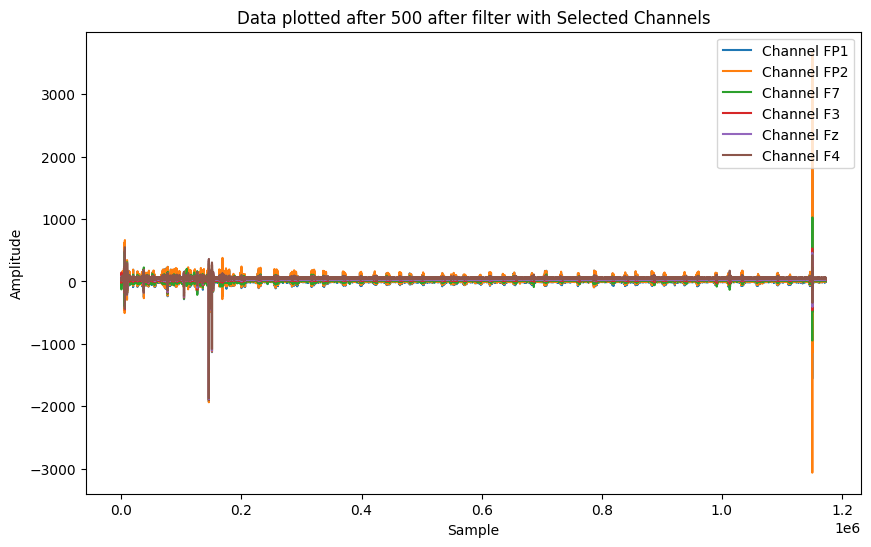

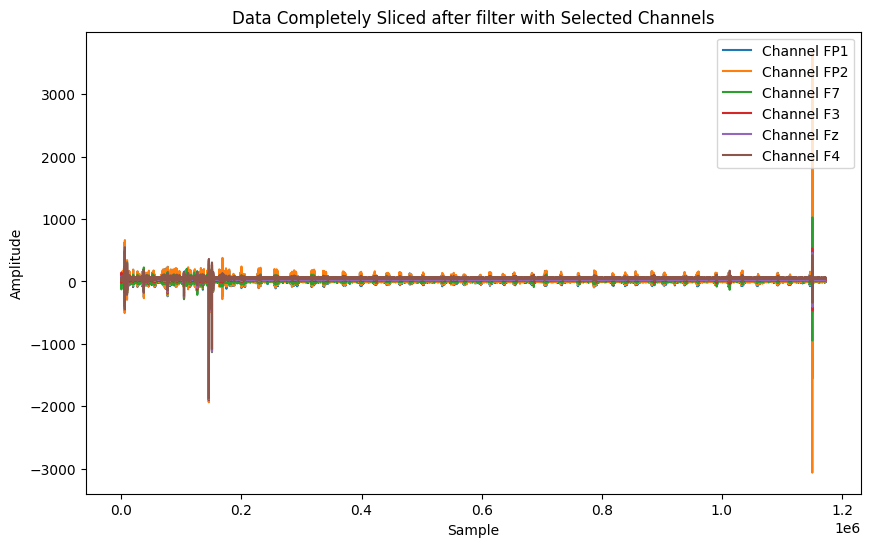

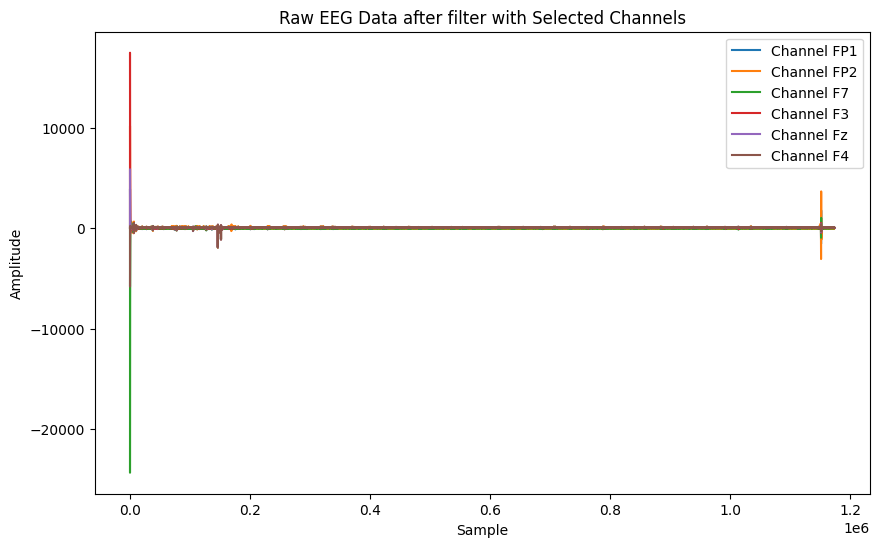

In [ ]:

from google.colab import output
output.enable_custom_widget_manager()
EEG = raw.filter(1, 40, fir_design='firwin')
EEG_sliced= raw_sliced.filter(1, 40, fir_design='firwin')
 # High-pass at 1 Hz and low-pass at 40 Hz
epsilon = np.finfo(float).eps
annotations, bads = mne.preprocessing.annotate_amplitude(EEG, flat=20*epsilon, min_duration=5, bad_percent=100)
EEG.set_annotations(annotations)

print("Channel names:")
for i, ch_name in enumerate(ch_names):
    print(f"{i}: {ch_name}")

# User input for channels to plot
selected_channels = input("Enter the indices of channels to plot (comma separated): ")
selected_channels = [int(ch) for ch in selected_channels.split(",")]

data_five= EEG.get_data()
sliced_data = data_five[:, 500:]
choose_eeg(sliced_data, ch_names, selected_channels, "Data plotted after 500 after filter with Selected Channels")
choose_eeg(EEG_sliced.get_data(),ch_names, selected_channels, "Data Completely Sliced after filter with Selected Channels")
choose_eeg(EEG.get_data(), ch_names, selected_channels, "Raw EEG Data after filter with Selected Channels")




# plot
#interactive_plot(raw, 'Original EEG Data')


#raw.plot(scalings="auto")
#EEG.plot(scalings="auto")



ASR

In [ ]:

## Train on a clean portion of data
asr = ASR(method="euclid")
train_idx = np.arange(0 * sfreq, 30 * sfreq, dtype=int)
raw_data = EEG.get_data()  # This extracts all data as a NumPy array
#train_data = raw_data[:, train_idx]
#_, sample_mask = asr.fit(train_data)
_, sample_mask = asr.fit(raw_data[:, train_idx])
raw_data = np.nan_to_num(raw_data)
 #sliced
raw_data_sliced= EEG_sliced.get_data()
_, sample_mask = asr.fit(raw_data_sliced[:, train_idx])
raw_data_sliced = np.nan_to_num(raw_data_sliced)
# Apply filter using sliding (non-overlapping) windows
X = sliding_window(raw_data, window=int(sfreq), step=int(sfreq))
Y = np.zeros_like(X)
for i in range(X.shape[1]):
    Y[:, i, :] = asr.transform(X[:, i, :])

A = sliding_window(raw_data_sliced, window=int(sfreq), step=int(sfreq))
B = np.zeros_like(A)
for i in range(A.shape[1]):
    B[:, i, :] = asr.transform(A[:, i, :])

raw_reshape= X.reshape(21, -1)  # reshape to (n_chans, n_times)
raw_data_clean = Y.reshape(21,-1)
raw_reshape_sliced= A.reshape(21, -1)  # reshape to (n_chans, n_times)
raw_data_clean_sliced = B.reshape(21,-1)

# Create a new Raw object with the cleaned data
info_clean = mne.create_info(ch_names=ch_names[:21], sfreq=512, ch_types=ch_types[:21])
raw_clean = mne.io.RawArray(raw_data_clean, info_clean)
raw_clean_sliced = mne.io.RawArray(raw_data_clean_sliced, info_clean)

raw_clean.set_montage(custom_montage)
raw_clean_sliced.set_montage(custom_montage)
#plot_eeg(raw, "after ASR" )



NameError: name 'ASR' is not defined

In [ ]:
print("Channel names:")
for i, ch_name in enumerate(ch_names):
    print(f"{i}: {ch_name}")

# User input for channels to plot
selected_channels = input("Enter the indices of channels to plot (comma separated): ")
selected_channels = [int(ch) for ch in selected_channels.split(",")]

choose_eeg(raw_clean.get_data(), ch_names, selected_channels, "After ASR EEG Data with Selected Channels")
choose_eeg(raw_clean_sliced.get_data(), ch_names, selected_channels, "After ASR EEG Data with Selected Channels")



In [ ]:
raw_clean.interpolate_bads(reset_bads=True)
raw_clean.set_eeg_reference('average', projection=True)
raw_clean.apply_proj()



In [ ]:
print("Channel names:")
for i, ch_name in enumerate(ch_names):
    print(f"{i}: {ch_name}")

# User input for channels to plot
selected_channels = input("Enter the indices of channels to plot (comma separated): ")
selected_channels = [int(ch) for ch in selected_channels.split(",")]

choose_eeg(raw_clean.get_data(), ch_names, selected_channels, "After ASR and interprolate (might not be working) EEG Data with Selected Channels")

In [ ]:
times = np.arange(raw.shape[-1]) / sfreq
f, ax = plt.subplots(8, sharex=True, figsize=(8, 5))
for i in range(8):
    ax[i].fill_between(train_idx / sfreq, 0, 1, color="grey", alpha=.3,
                       transform=ax[i].get_xaxis_transform(),
                       label="calibration window")
    ax[i].fill_between(train_idx / sfreq, 0, 1, where=sample_mask.flat,
                       transform=ax[i].get_xaxis_transform(),
                       facecolor="none", hatch="...", edgecolor="k",
                       label="selected window")
    ax[i].plot(times, raw[i], lw=.5, label="before ASR")
    ax[i].plot(times, clean[i], label="after ASR", lw=.5)
    ax[i].set_ylim([-50, 50])
    ax[i].set_ylabel(f"ch{i}")
    ax[i].set_yticks([])
ax[i].set_xlabel("Time (s)")
ax[0].legend(fontsize="small", bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.subplots_adjust(hspace=0, right=0.75)
plt.suptitle("Before/after ASR")
plt.show()

In [ ]:
print(EEGdata.shape)
plt.plot(EEGdata[1,500:], color='b')